# Board Games Rank Prediction

# Project description
Aim of this project is to predict what will be the rank of a board game with given attributes.

# Libraries and dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Dataset
Original dataset comes from [Kaggle](https://www.kaggle.com/datasets/joebeachcapital/board-games).
Dataset used in the project consists of two merged files: 
- File *details* containing basic information about board games available on the site,
- File *ratings* containing games' ratings

Data has been gathered on Feb 2024.

In [2]:
df_details = pd.read_csv("Data/details.csv", 
                         index_col="id"
                        )
df_ratings = pd.read_csv("Data/ratings.csv", 
                        index_col="id",
                         usecols=["id", "year", "rank", "average", "bayes_average", "users_rated"]
                        )
df = pd.merge(df_details, df_ratings, how="left", on="id")

In [3]:
df.head()

,num,primary,description,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,...,boardgamepublisher,owned,trading,wanting,wishing,year,rank,average,bayes_average,users_rated
id,,,,,,,,,,,,,,,,,,,,,
30549,0,Pandemic,"In Pandemic, several virulent diseases have br...",2008,2,4,45,45,45,8,...,"['Z-Man Games', 'Albi', 'Asmodee', 'Asmodee It...",168364,2508,625,9344,2008,106,7.59,7.487,108975
822,1,Carcassonne,Carcassonne is a tile-placement game in which ...,2000,2,5,45,30,45,7,...,"['Hans im Glück', '999 Games', 'Albi', 'Bard C...",161299,1716,582,7383,2000,190,7.42,7.309,108738
13,2,Catan,"In CATAN (formerly The Settlers of Catan), pla...",1995,3,4,120,60,120,10,...,"['KOSMOS', '999 Games', 'Albi', 'Asmodee', 'As...",167733,2018,485,5890,1995,429,7.14,6.970,108024
68448,3,7 Wonders,You are the leader of one of the 7 great citie...,2010,2,7,30,30,30,10,...,"['Repos Production', 'ADC Blackfire Entertainm...",120466,1567,1010,12105,2010,73,7.74,7.634,89982
36218,4,Dominion,"&quot;You are a monarch, like your parents bef...",2008,2,4,30,30,30,13,...,"['Rio Grande Games', '999 Games', 'Albi', 'Bar...",106956,2009,655,8621,2008,104,7.61,7.499,81561


In [4]:
df.shape

(21631, 27)

In [5]:
df.describe()

,num,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,owned,trading,wanting,wishing,year,rank,average,bayes_average,users_rated
count,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000
mean,10815.000000,1986.094910,2.007027,5.709491,90.509177,63.647774,90.509177,9.611391,1487.924553,43.585965,42.030373,233.655587,1988.101290,10879.522352,6.417249,5.683664,874.548518
std,6244.476172,210.042496,0.688957,15.102385,534.826511,447.213702,534.826511,3.640562,5395.077773,102.410851,117.940355,800.657809,190.115056,6311.917913,0.929345,0.366096,3695.946026
min,0.000000,-3500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.040000,0.000000,30.000000
25%,5407.500000,2001.000000,2.000000,4.000000,25.000000,20.000000,25.000000,8.000000,150.000000,5.000000,3.000000,14.000000,2001.000000,5408.500000,5.830000,5.510000,57.000000
50%,10815.000000,2011.000000,2.000000,4.000000,45.000000,30.000000,45.000000,10.000000,322.000000,13.000000,9.000000,39.000000,2011.000000,10839.000000,6.450000,5.546000,124.000000
75%,16222.500000,2017.000000,2.000000,6.000000,90.000000,60.000000,90.000000,12.000000,903.500000,38.000000,29.000000,131.000000,2017.000000,16356.500000,7.040000,5.678000,397.000000
max,21630.000000,2023.000000,10.000000,999.000000,60000.000000,60000.000000,60000.000000,25.000000,168364.000000,2508.000000,2011.000000,19325.000000,3500.000000,21831.000000,9.570000,8.511000,108975.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21631 entries, 30549 to 165946
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   num                      21631 non-null  int64  
 1   primary                  21631 non-null  object 
 2   description              21630 non-null  object 
 3   yearpublished            21631 non-null  int64  
 4   minplayers               21631 non-null  int64  
 5   maxplayers               21631 non-null  int64  
 6   playingtime              21631 non-null  int64  
 7   minplaytime              21631 non-null  int64  
 8   maxplaytime              21631 non-null  int64  
 9   minage                   21631 non-null  int64  
 10  boardgamecategory        21348 non-null  object 
 11  boardgamemechanic        20041 non-null  object 
 12  boardgamefamily          17870 non-null  object 
 13  boardgameexpansion       5506 non-null   object 
 14  boardgameimplemen

In [7]:
df.isnull().sum()

num                            0
primary                        0
description                    1
yearpublished                  0
minplayers                     0
maxplayers                     0
playingtime                    0
minplaytime                    0
maxplaytime                    0
minage                         0
boardgamecategory            283
boardgamemechanic           1590
boardgamefamily             3761
boardgameexpansion         16125
boardgameimplementation    16769
boardgamedesigner            596
boardgameartist             5907
boardgamepublisher             1
owned                          0
trading                        0
wanting                        0
wishing                        0
year                           0
rank                           0
average                        0
bayes_average                  0
users_rated                    0
dtype: int64

In [8]:
df.duplicated().sum()

0

Dataset consists **mainly** of numeric columns with non-null values. There are some strings and lists objects as well, which may be null. There are no duplicated rows.

# Exploratory Data analysis (EDA)

## Data cleaning and Preprocessing

### Drop unnecessary columns

Remove any columns that are not relevant to your analysis. Use .drop() in pandas.

In [9]:
df.columns

Index(['num', 'primary', 'description', 'yearpublished', 'minplayers',
       'maxplayers', 'playingtime', 'minplaytime', 'maxplaytime', 'minage',
       'boardgamecategory', 'boardgamemechanic', 'boardgamefamily',
       'boardgameexpansion', 'boardgameimplementation', 'boardgamedesigner',
       'boardgameartist', 'boardgamepublisher', 'owned', 'trading', 'wanting',
       'wishing', 'year', 'rank', 'average', 'bayes_average', 'users_rated'],
      dtype='object')

In [10]:
df = df.drop(["num", "description", "boardgameexpansion", "boardgameimplementation",
             "boardgameartist", "boardgamepublisher", "year"], axis=1)

### Rename columns

In [11]:
cols_dict = {"primary": "name",
            "yearpublished": "year_published",
            "minplayers": "min_players",
            "maxplayers": "max_players",
            "playingtime": "playing_time",
            "minplaytime": "min_playtime",
            "maxplaytime": "max_playtime",
            "minage": "min_age",
            "boardgamecategory": "game_category",
            "boardgamemechanic": "game_mechanic",
            "boardgamefamily": "game_family",
            "boardgamedesigner": "game_designer"
            }
df = df.rename(cols_dict, axis=1)
df.columns

Index(['name', 'year_published', 'min_players', 'max_players', 'playing_time',
       'min_playtime', 'max_playtime', 'min_age', 'game_category',
       'game_mechanic', 'game_family', 'game_designer', 'owned', 'trading',
       'wanting', 'wishing', 'rank', 'average', 'bayes_average',
       'users_rated'],
      dtype='object')

### Reorder columns

In [12]:
# List of columns to reorder
reordered_columns = ["rank", "name", "average", "bayes_average", "owned", "wanting", "wishing", "users_rated"]

# List of columns that are not being reordered
remaining_columns = [col for col in df.columns if col not in reordered_columns]

# Concatenate reordered columns with the remaining columns
df_reordered = pd.concat([df[reordered_columns], df[remaining_columns]], axis=1)

In [13]:
# Convert pd.NA to empty string
df['game_category'].fillna('', inplace=True)

In [14]:
df = df_reordered.sort_values("rank")
df.head()

,rank,name,average,bayes_average,owned,wanting,wishing,users_rated,year_published,min_players,max_players,playing_time,min_playtime,max_playtime,min_age,game_category,game_mechanic,game_family,game_designer,trading
id,,,,,,,,,,,,,,,,,,,,
174430,1,Gloomhaven,8.74,8.511,77758,1346,17658,47827,2017,1,4,120,60,120,14,"['Adventure', 'Exploration', 'Fantasy', 'Fight...","['Action Queue', 'Action Retrieval', 'Campaign...","['Category: Dungeon Crawler', 'Components: Min...",['Isaac Childres'],648
161936,2,Pandemic Legacy: Season 1,8.59,8.442,70830,831,11729,45041,2015,2,4,60,60,60,13,"['Environmental', 'Medical']","['Action Points', 'Cooperative Game', 'Hand Ma...","['Components: Map (Global Scale)', 'Components...","['Rob Daviau', 'Matt Leacock']",327
224517,3,Brass: Birmingham,8.66,8.418,38126,1522,11846,25484,2018,2,4,120,60,120,14,"['Economic', 'Industry / Manufacturing', 'Post...","['Hand Management', 'Income', 'Loans', 'Market...","['Cities: Birmingham (England)', 'Country: Eng...","['Gavan Brown', 'Matt Tolman', 'Martin Wallace']",128
167791,4,Terraforming Mars,8.42,8.274,101872,2011,19227,74216,2016,1,5,120,120,120,12,"['Economic', 'Environmental', 'Industry / Manu...","['Drafting', 'End Game Bonuses', 'Hand Managem...","['Components: Map (Global Scale)', 'Components...",['Jacob Fryxelius'],538
233078,5,Twilight Imperium: Fourth Edition,8.68,8.262,20542,986,8984,16025,2017,3,6,480,240,480,14,"['Civilization', 'Economic', 'Exploration', 'N...","['Action Drafting', 'Area Majority / Influence...","['Components: Hexagonal Tiles', 'Components: M...","['Dane Beltrami', 'Corey Konieczka', 'Christia...",120


## Data Visualization

Now we can visualize the data to gain insights:

    .hist() for histograms
    .plot() for line plots, scatter plots, etc.
    .value_counts() to see counts of categorical variables
    .describe() for summary statistics

### Histograms

Use .hist() in pandas to get a visual representation of the distribution of a numeric variable. This can reveal outliers, skewness, and other patterns.

### Box plots

Use .boxplot() in pandas to visualize the distribution through quartiles, extremes, and outliers for a numeric variable.

### Scatter plots

Use .plot(kind=’scatter’) to visualize the relationship between two numeric variables. This can reveal correlations, clusters, and outliers.

### Bar plots

Use .plot(kind=’bar’) to compare categorical variables or the counts of categorical variables. This gives a quick visual summary.

### Line plots

Use .plot(kind=’line’) to visualize trends over time for time series data.

### Pair plots

Use seaborn pairplot() to visualize the relationships between all variables in a dataset.

### Correlation heatmaps

Use a seaborn heatmap() to visualize the correlation between all numeric variables.

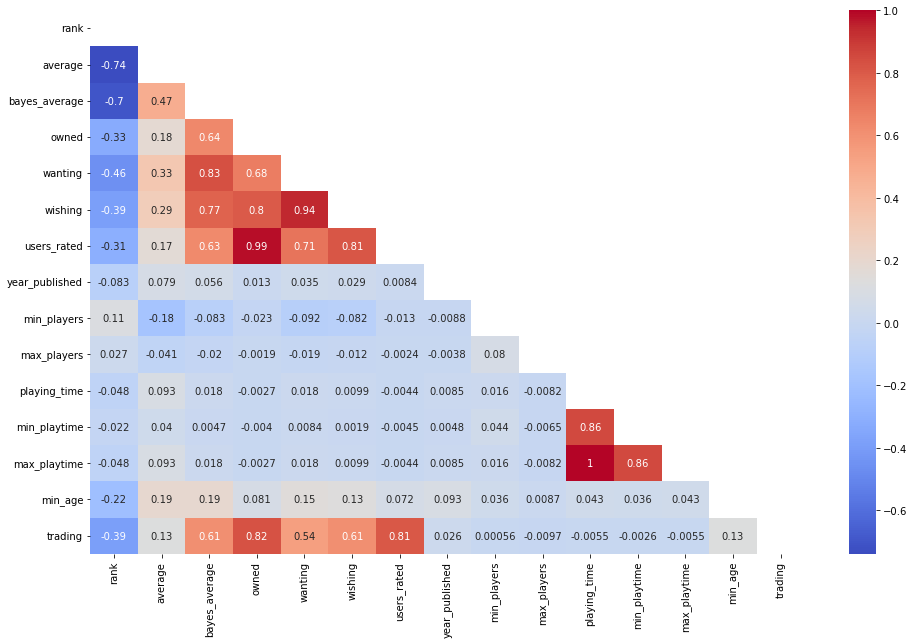

In [15]:
corr = df.corr()
matrix = np.triu(corr)
plt.figure(figsize=(16,10))

# using the upper triangle matrix as mask 
sns.heatmap(corr, annot=True, mask=matrix, cmap="coolwarm")
plt.show()

Correlation between rank and other variables is nnegative. That means: the higher numbers get, the lower rank is - meaning that game should be considered as "good".

### Descriptive statistics

In [67]:
df.describe()

,rank,average,bayes_average,owned,wanting,wishing,users_rated,year_published,min_players,max_players,playing_time,min_playtime,max_playtime,min_age,trading
count,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000
mean,10879.522352,6.417249,5.683664,1487.924553,42.030373,233.655587,874.548518,1986.094910,2.007027,5.709491,90.509177,63.647774,90.509177,9.611391,43.585965
std,6311.917913,0.929345,0.366096,5395.077773,117.940355,800.657809,3695.946026,210.042496,0.688957,15.102385,534.826511,447.213702,534.826511,3.640562,102.410851
min,1.000000,1.040000,0.000000,0.000000,0.000000,0.000000,30.000000,-3500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5408.500000,5.830000,5.510000,150.000000,3.000000,14.000000,57.000000,2001.000000,2.000000,4.000000,25.000000,20.000000,25.000000,8.000000,5.000000
50%,10839.000000,6.450000,5.546000,322.000000,9.000000,39.000000,124.000000,2011.000000,2.000000,4.000000,45.000000,30.000000,45.000000,10.000000,13.000000
75%,16356.500000,7.040000,5.678000,903.500000,29.000000,131.000000,397.000000,2017.000000,2.000000,6.000000,90.000000,60.000000,90.000000,12.000000,38.000000
max,21831.000000,9.570000,8.511000,168364.000000,2011.000000,19325.000000,108975.000000,2023.000000,10.000000,999.000000,60000.000000,60000.000000,60000.000000,25.000000,2508.000000


# Model selection

## Preparing the variables and labels

In [16]:
data_only_numeric_cols = df.select_dtypes(include=['float64','int64'])
X = data_only_numeric_cols.drop(['rank'] , axis=1)
y = df['rank']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Data scaling

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Hyperparameter tuning

In [19]:
# Linear Regression
lr_model = LinearRegression()
lr_param_grid = {}  # No hyperparameters to tune for Linear Regression

# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Support Vector Machine Regressor
svm_model = SVR()
svm_param_grid = {
    'C': [0.1, 1.0, 10.0],
    'epsilon': [0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf']
}

### GridSearchCV for each model

In [ ]:
# To reload the trained GridSearchCV object
with open('lr_grid_search.pkl', 'rb') as file:
    lr_grid_search = pickle.load(file)

In [20]:
# lr_grid_search = GridSearchCV(lr_model, lr_param_grid, cv=5, scoring='neg_mean_squared_error')
# lr_grid_search.fit(X_train_scaled, y_train)

# # Save the trained GridSearchCV object to a file (after fitting the GridSearch)
# with open('Models/lr_grid_search.pkl', 'wb') as file:
#     pickle.dump(rf_grid_search, file)

GridSearchCV(cv=5, estimator=LinearRegression(), param_grid={},
             scoring='neg_mean_squared_error')

In [52]:
# No parameteres for Linear Regression
lr_grid_search.best_params_

{}

In [ ]:
# To reload the trained GridSearchCV object
with open('rf_grid_search.pkl', 'rb') as file:
    rf_grid_search = pickle.load(file)

In [21]:
# rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='neg_mean_squared_error')
# rf_grid_search.fit(X_train_scaled, y_train)

# # Save the trained GridSearchCV object to a file (after fitting the GridSearch)
# with open('Models/rf_grid_search.pkl', 'wb') as file:
#     pickle.dump(rf_grid_search, file)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [51]:
rf_grid_search.best_params_

{'max_depth': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 300}

In [ ]:
# To reload the trained GridSearchCV object
with open('svm_grid_search.pkl', 'rb') as file:
    svm_grid_search = pickle.load(file)

In [22]:
# svm_grid_search = GridSearchCV(svm_model, svm_param_grid, cv=5, scoring='neg_mean_squared_error')
# svm_grid_search.fit(X_train_scaled, y_train)

# # Save the trained GridSearchCV object to a file (after fitting the GridSearch)
# with open('Models/svm_grid_search.pkl', 'wb') as file:
#     pickle.dump(rf_grid_search, file)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.1, 1.0, 10.0], 'epsilon': [0.1, 0.01, 0.001],
                         'kernel': ['linear', 'rbf']},
             scoring='neg_mean_squared_error')

In [50]:
svm_grid_search.best_params_

{'C': 10.0, 'epsilon': 0.1, 'kernel': 'rbf'}

In [30]:
# Making predictions
lr_predictions = lr_grid_search.predict(X_test_scaled)
rf_predictions = rf_grid_search.predict(X_test_scaled)
svm_predictions = svm_grid_search.predict(X_test_scaled)

# Calculating RMSE (Root Mean Squared Error) for evaluation
lr_rmse = mean_squared_error(y_test, lr_predictions, squared=False)
rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)
svm_rmse = mean_squared_error(y_test, svm_predictions, squared=False)

lr_r2 = r2_score(y_test, lr_predictions)
rf_r2 = r2_score(y_test, rf_predictions)
svm_r2 = r2_score(y_test, svm_predictions)

print(f"Linear Regression RMSE: {lr_rmse:.3f}; R2: {lr_r2:.3f}")
print(f"Random Forest RMSE: {rf_rmse:.3f}; R2: {rf_r2:.3f}")
print(f"SVM RMSE: {svm_rmse:.3f}; R2: {svm_r2:.3f}")

Linear Regression RMSE: 3158.325; R2: 0.744
Random Forest RMSE: 30.847; R2: 1.000
SVM RMSE: 3029.970; R2: 0.764


## Final models

In [59]:
model_lr = LinearRegression()

In [60]:
model_rf = RandomForestRegressor(random_state=42,
                                 max_depth= 10,
                                 min_samples_leaf= 4,
                                 min_samples_split= 2,
                                 n_estimators= 300)

In [61]:
model_svm = SVR(C=10.0,
                epsilon=0.1,
                kernel='rbf')

In [66]:
def model_scores(model_name, model):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    MSE = mean_squared_error(y_test, y_pred)
    R2 = r2_score(y_test, y_pred)

    return MSE, R2


models_dict = {"Linear Regression": model_lr,
         "Random Forest": model_rf,
         "SVM": model_svm}

for model_name, model in models_dict.items():
    scores = model_scores(model_name, model)
    print(f"Results for {model_name}:")
    print(f"Mean Squared Error: {scores[0]:.3f}")
    print(f"R-squared:  {scores[1]:.3f} \n")

Results for Linear Regression:
Mean Squared Error: 9975017.847317003
R-squared:  0.7440068265786577 

Results for Random Forest:
Mean Squared Error: 951.5596434937484
R-squared:  0.9999755797155888 

Results for SVM:
Mean Squared Error: 9180718.081664644
R-squared:  0.7643912831049051 



# Commentary

For given dataset, out of 3 tested models, best works random forest. Mean squared error is 951 which means the model is estimating the **rank** wrong by approximately 31 places.

Linear regression, does not work well with this dataset, as there is no linear trend. Support Vector Machines also does not make a good fit into solving this kind of problem.

In my opinion it is a good result, because there are lots of factors that are hard to model, but have strong influence on the board game's rating performance, such as marketing strategy and viral trends.